In [1]:
# coding: utf-8
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pylab as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor

import sklearn.kernel_approximation
import scipy.optimize as opt

%matplotlib inline

In [2]:
class GPUCB(object):

    def __init__(self, x, environment, alpha, beta=1.):
        '''
        environment: Environment class which is equipped with sample() method to
        return observed value.
        beta (optional): Hyper-parameter to tune the exploration-exploitation
        balance. If beta is large, it emphasizes the variance of the unexplored
        solution solution (i.e. larger curiosity)
        '''
        self.x = x
        self.environment = environment
        self.alpha = alpha
        self.beta = beta

        # self.X_grid = self.meshgrid.reshape(self.meshgrid.shape[0], -1).T
        self.mu = np.zeros_like(x)
        self.sigma = 0.5 * np.ones_like(x)
        self.X = []
        self.T = []
        self.cumu_regret = 0
        self.regret_list = []
        self.trueT = self.environment.sample(self.x)
        #self.x_maxlabel = self.x[np.argmax(np.sin(self.x))]
        self.maxlabel = np.max(np.sin(self.x))

    def argmax_ucb(self):
        return np.argmax(self.mu + self.sigma * np.sqrt(self.beta))

    def regret(self):
        #if self.X[-1] != self.x_maxlabel:
        #    self.cumu_regret += 1
        if self.T[-1] < self.maxlabel:
            self.cumu_regret += self.maxlabel - self.T[-1]
        self.regret_list.append(self.cumu_regret)

    def learn(self):
        grid_idx = self.argmax_ucb()
        self.sample(self.x[grid_idx])
        self.regret()
        gp = GaussianProcessRegressor(alpha = self.alpha)
        gp.fit(self.X, self.T)
        self.mu, self.sigma = gp.predict(self.x.reshape((self.x.shape[0],1)), return_std=True)

    def sample(self, x):
        t = self.environment.sample(x)
        self.X.append([x])
        self.T.append(t)

    def plot(self):
        fig = plt.figure()
        # ax = Axes3D(fig)
        ax = plt.axes()
        ax.plot(self.x, self.mu, alpha=0.5, color='g', label = 'predict')
        #plt.fill_between(xs, xs_ @ opt_l, xs_ @ opt_u, facecolor='k', alpha=0.2)
        ax.fill_between(self.x, self.mu + self.sigma, self.mu - self.sigma, facecolor='k', alpha=0.2)
        #ax.plot(self.x, self.trueT,  alpha=0.5, color='b')
        ax.scatter(self.X, self.T, c='r', marker='o', alpha=1.0, label = 'groundtruth')
        plt.legend()
        #plt.savefig('fig_%02d.png' % len(self.X))
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('GPUCB')
        plt.show()

In [3]:
class QuantUCB(object):

    def __init__(self, x, environment, up, lq, beta=1.):
        '''
        environment: Environment class which is equipped with sample() method to
        return observed value.
        beta (optional): Hyper-parameter to tune the exploration-exploitation
        balance. If beta is large, it emphasizes the variance of the unexplored
        solution solution (i.e. larger curiosity)
        '''
        #self.x = x
        self.x = np.stack([x.ravel(), np.ones_like(x.ravel())]).T
        #print('self.x shape:', self.x.shape)
        self.environment = environment
        self.beta = beta
        self.uq = up
        self.lq = lq

        self.X = []
        self.T = []
        self.cumu_regret = 0
        self.regret_list = []
        self.trueT = self.environment.sample(self.x[:,0])
        #self.x_maxlabel = self.x[np.argmax(np.sin(self.x[:,0])),0]
        self.maxlabel = np.max(np.sin(self.x[:,0]))
        
        self.predict = np.zeros_like(self.x)
        self.ub = 0.5 * np.ones_like(self.x)
        self.lb = -0.5 * np.ones_like(self.x)
        
        self.D = 50
        self.sampler = sklearn.kernel_approximation.RBFSampler(n_components= self.D, gamma=0.1)
        
    def argmax_ucb(self):
        # use upper bound
        # return np.argmax(self.ub)
        
        # use predict + uncertainty
        return np.argmax(self.predict + 0.5 * abs(self.ub - self.lb) * np.sqrt(self.beta))

    def regret(self):
        if self.T[-1] < self.maxlabel:
            self.cumu_regret += self.maxlabel - self.T[-1]
        #if self.X[-1] != self.x_maxlabel:
        #    self.cumu_regret += 1
        self.regret_list.append(self.cumu_regret)
        
    def cost(self, W, X, Y, q):
        predictions = X @ W
        return np.where(
            predictions > Y,
            (1 - q) * np.abs(Y - predictions),
            q * np.abs(Y - predictions)).sum()
    
    def opti(self, X,Y):
        self.opt_w = opt.fmin_bfgs(self.cost, np.zeros((self.D,)), args=(X, Y, 0.5), disp = False)
        self.opt_u = opt.fmin_bfgs(self.cost, np.zeros((self.D,)), args=(X, Y, self.uq), disp = False)
        self.opt_l = opt.fmin_bfgs(self.cost, np.zeros((self.D,)), args=(X, Y, self.lq), disp = False)

    def learn(self):
        grid_idx = self.argmax_ucb()
        #print('grid_idx:', grid_idx)
        self.sample(grid_idx)
        self.regret()
        
        X_ = np.asarray(self.X)
        X_ = np.stack([X_.ravel(), np.ones_like(X_.ravel())]).T
        #print('X_ shape:', X_.shape)
        #print('X_', X_)
        
        X_rbf = self.sampler.fit_transform(X_)
        #print('X_rbf shape:', X_rbf.shape)
        #print('X_rbf', X_rbf)
        self.opti(X_rbf, np.asarray(self.T))
        
        self.x_ = self.sampler.transform(self.x)
        #print('self.x_ shape:', self.x_.shape)
        #print('self.x_', self.x_)
        self.predict = self.x_ @ self.opt_w
        #print('predictions:', self.predict)
        self.ub = self.x_ @ self.opt_u
        #print('upper bound:', self.ub)
        self.lb = self.x_ @ self.opt_l
        #print('lower bound:', self.lb)

    def sample(self, idx):
        #print('selected x', self.x[idx,0])
        t = self.environment.sample(self.x[idx,0])
        #print('sample:', t)
        self.X.append(self.x[idx,0])
        self.T.append(t)

    def plot(self):
        fig = plt.figure()
        # ax = Axes3D(fig)
        ax = plt.axes()
        '''
        ax.plot_wireframe(self.meshgrid[0], self.meshgrid[1],
            self.mu.reshape(self.meshgrid[0].shape), alpha=0.5, color='g')
        ax.plot_wireframe(self.meshgrid[0], self.meshgrid[1],
            self.environment.sample(self.meshgrid), alpha=0.5, color='b')
        ax.scatter([x[0] for x in self.X], [x[1] for x in self.X], self.T, c='r',
            marker='o', alpha=1.0)
        '''
        ax.plot(self.x[:,0], self.predict, alpha=0.5, color='g', label = 'predict')
        #plt.fill_between(xs, xs_ @ opt_l, xs_ @ opt_u, facecolor='k', alpha=0.2)
        ax.fill_between(self.x[:,0], self.lb, self.ub, facecolor='k', alpha=0.2)
        #ax.plot(self.x[:,0], self.trueT,  alpha=0.5, color='b')
        ax.scatter(self.X, self.T, c='r', marker='o', alpha=1.0, label = 'sample')
        #plt.savefig('fig_%02d.png' % len(self.X))
        plt.legend()
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('QuantUCB')
        plt.show()

In [4]:
class DummyEnvironment(object):
    def sample(self, x):
        noise = np.random.normal(0,0.1,1)
        return np.sin(x) + noise[0]
        #return np.sin(x)

x = np.arange(-3, 3, 0.1)
# y = np.arange(-3, 3, 0.25)
env = DummyEnvironment()

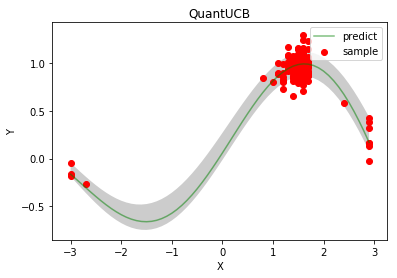

In [5]:
uq = 0.9
lq = 0.1
QuantAgent = QuantUCB(x, env, uq, lq)
for i in range(200):
    QuantAgent.learn()
QuantAgent.plot()  

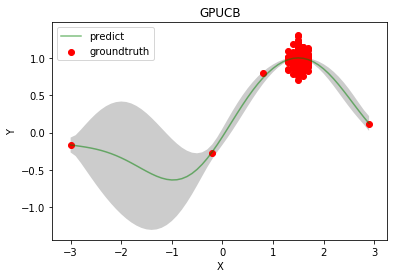

In [6]:
alpha = 0.01 
GPAgent = GPUCB(x, env, alpha)
for i in range(200):
    GPAgent.learn() 
GPAgent.plot()

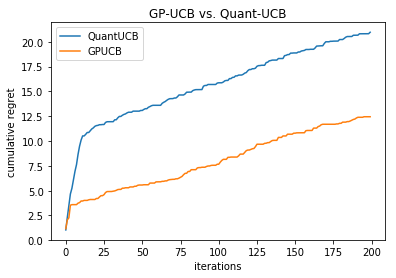

In [7]:
# plot cumulative regret
plt.plot(range(200), QuantAgent.regret_list, label = 'QuantUCB')
plt.plot(range(200), GPAgent.regret_list, label = 'GPUCB')
plt.xlabel('iterations')
plt.ylabel('cumulative regret')
plt.title('GP-UCB vs. Quant-UCB')
plt.legend()

In [8]:
GPAgent.sigma

array([ 0.09950326,  0.14019795,  0.21962932,  0.30615094,  0.39136575,
        0.4719865 ,  0.54609445,  0.6123329 ,  0.66967513,  0.71733642,
        0.75472975,  0.78143819,  0.79719757,  0.80188894,  0.7955416 ,
        0.7783471 ,  0.75068229,  0.71313835,  0.66655067,  0.61202392,
        0.55094735,  0.48499701,  0.41612652,  0.34655675,  0.27879307,
        0.21573998,  0.16106353,  0.11992373,  0.09862163,  0.09804972,
        0.10873123,  0.1206314 ,  0.12876905,  0.13151094,  0.12881637,
        0.12139508,  0.11029903,  0.09669585,  0.08173421,  0.06646849,
        0.0518231 ,  0.03857223,  0.02729798,  0.0182914 ,  0.01150206,
        0.0075374 ,  0.01017583,  0.01895621,  0.0313636 ,  0.04638184,
        0.06296897,  0.07978602,  0.09526497,  0.10775753,  0.11573557,
        0.11806261,  0.11441778,  0.10610407,  0.09768719,  0.09874168])

In [9]:
QuantAgent.ub - QuantAgent.lb

array([ 0.14290835,  0.15184411,  0.16104085,  0.1704294 ,  0.17993779,
        0.18949214,  0.1990175 ,  0.20843871,  0.21768136,  0.22667264,
        0.23534225,  0.24362325,  0.25145286,  0.2587733 ,  0.26553248,
        0.2716847 ,  0.27719123,  0.28202082,  0.28615018,  0.28956429,
        0.29225669,  0.29422958,  0.29549392,  0.29606938,  0.29598413,
        0.29527467,  0.29398538,  0.29216816,  0.28988181,  0.28719144,
        0.28416773,  0.28088617,  0.27742619,  0.27387027,  0.27030297,
        0.26680996,  0.263477  ,  0.26038891,  0.25762859,  0.25527593,
        0.25340688,  0.25209247,  0.2513979 ,  0.25138167,  0.2520948 ,
        0.2535801 ,  0.25587155,  0.25899373,  0.26296139,  0.26777911,
        0.27344108,  0.27993092,  0.28722174,  0.29527623,  0.30404684,
        0.31347618,  0.32349742,  0.33403488,  0.34500466,  0.3563154 ])

In [10]:
GPAgent.maxlabel

0.999573603041505

In [11]:
X = np.asarray(QuantAgent.X)
X = X.reshape(X.shape[0],1)

T = np.asarray(QuantAgent.T)
T = T.reshape(T.shape[0],1)

import pandas as pd

data = pd.DataFrame(data = np.hstack([X, T]), columns = ['x', 'y'])
data.head()

,x,y
0,-3.0,-0.044746
1,-2.7,-0.266873
2,-3.0,-0.165608
3,-3.0,-0.187655
4,2.9,0.424465
